# Homework: 2024.9.11
多智能体（multi_agent_collaboration）实战

## 1. 使用不同的大模型运行多智能体，对比结果并评选 gpt-4o 之下最好的大模型，将所有的大模型和最终结果生成一张表格；

In [1]:
%%capture --no-stderr
%pip install langchain langchain_openai langsmith pandas langchain_experimental matplotlib langgraph langchain_core

In [2]:
import os
# 可选：在 LangSmith 中添加追踪功能
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "Multi-agent Collaboration"

In [3]:
# 1. 定义工具
from typing import Annotated

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool
from langchain_experimental.utilities import PythonREPL

# Tavily 搜索工具，用于搜索
tavily_tool = TavilySearchResults(max_results=5)

# Python REPL 工具，用于执行 Python 代码
repl = PythonREPL()

@tool
def python_repl(
    code: Annotated[str, "The python code to execute to generate your chart."],
):
    """Use this to execute python code. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"


    return f"Successfully executed:\n```python\n{code}\n```\n"

        
from langgraph.prebuilt import ToolNode

# 定义工具列表，包括 Tavily 搜索工具和 Python REPL 工具
tools = [tavily_tool, python_repl]

# 创建工具节点，负责工具的调用
tool_node = ToolNode(tools)

In [4]:
# 2. 辅助函数：智能体节点
import functools
from langchain_core.messages import AIMessage
from langchain_openai import ChatOpenAI

# 辅助函数：为智能体创建一个节点
def agent_node(state, agent, name):
    # 修正名称格式，移除空格并确保只包含合法字符
    name = name.replace(" ", "_").replace("-", "_")  # 确保符合正则表达式要求

    # 调用智能体，获取结果
    result = agent.invoke(state)
    
    # 将智能体的输出转换为适合追加到全局状态的格式
    if isinstance(result, ToolMessage):
        pass  # 如果是工具消息，跳过处理
    else:
        # 将结果转换为 AIMessage，并排除部分字段
        result = AIMessage(**result.dict(exclude={"type", "name"}), name=name)
    
    # 返回更新后的状态，包括消息和发送者
    return {
        "messages": [result],  # 包含新生成的消息
        # 我们使用严格的工作流程，通过记录发送者来知道接下来传递给谁
        "sender": name,
    }

In [5]:
# 3. 辅助函数：创建智能体
from langchain_core.messages import BaseMessage, HumanMessage, ToolMessage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langgraph.graph import END, StateGraph, START


# 创建智能体的函数，绑定 LLM（大型语言模型） 和工具
def create_agent(llm, tools, tool_message: str, custom_notice: str=""):
    """创建一个智能体。"""
    # 定义智能体的提示模板，包含系统消息和工具信息
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                "You are a helpful AI assistant, collaborating with other assistants."
                " Use the provided tools to progress towards answering the question."
                " If you are unable to fully answer, that's OK, another assistant with different tools "
                " will help where you left off. Execute what you can to make progress."
                " If you or any of the other assistants have the final answer or deliverable,"
                " prefix your response with FINAL ANSWER so the team knows to stop."
                "\n{custom_notice}\n"
                " You have access to the following tools: {tool_names}.\n{tool_message}\n\n",
            ),
            MessagesPlaceholder(variable_name="messages"),  # 用于替换的消息占位符

        ]
    )

    # 将系统消息部分和工具名称插入到提示模板中
    prompt = prompt.partial(tool_message=tool_message, custom_notice=custom_notice)
    prompt = prompt.partial(tool_names=", ".join([tool.name for tool in tools]))
      
    # 将提示模板与语言模型和工具绑定
    return prompt | llm.bind_tools(tools)


In [6]:
import operator
from typing import Annotated, Sequence, TypedDict

# 定义图中传递的对象，包含消息和发送者信息
class AgentState(TypedDict):
    # messages 是传递的消息，使用 Annotated 和 Sequence 来标记类型
    messages: Annotated[Sequence[BaseMessage], operator.add]
    # sender 是发送消息的智能体
    sender: str

In [7]:
from typing import Literal

# 路由器函数，用于决定下一步是执行工具还是结束任务
def router(state) -> Literal["call_tool", "__end__", "continue"]:
    messages = state["messages"]  # 获取当前状态中的消息列表
    last_message = messages[-1]  # 获取最新的一条消息
    
    # 如果最新消息包含工具调用，则返回 "call_tool"，指示执行工具
    if last_message.tool_calls:
        return "call_tool"
    
    # 如果最新消息中包含 "FINAL ANSWER"，表示任务已完成，返回 "__end__" 结束工作流
    if "FINAL ANSWER" in last_message.content:
        return "__end__"
    
    # 如果既没有工具调用也没有完成任务，继续流程，返回 "continue"
    return "continue"

In [8]:
def create_research_node(model="gpt-4o-mini"):
    # 研究智能体及其节点
    research_llm = ChatOpenAI(model=model)
    research_agent = create_agent(
        research_llm,  # 使用 research_llm 作为研究智能体的语言模型
        [tavily_tool],  # 研究智能体使用 Tavily 搜索工具
        tool_message=(
            "Before using the search engine, carefully think through and clarify the query."
            " Then, conduct a single search that addresses all aspects of the query in one go",
        ),
        custom_notice=(
            "Notice:\n"
            "Only gather and organize information. Do not generate code or give final conclusions, leave that for other assistants."
        ),
    )
    research_node = functools.partial(agent_node, agent=research_agent, name="Researcher")
    return research_node

def create_chart_node(model="gpt-4o-mini"):
    # 图表生成器智能体及其节点
    chart_llm = ChatOpenAI(model=model)
    chart_agent = create_agent(
        chart_llm,  # 使用 chart_llm 作为图表生成器智能体的语言模型
        [python_repl],  # 图表生成器智能体使用 Python REPL 工具
        tool_message="Create clear and user-friendly charts based on the provided data.",  # 系统消息，指导智能体如何生成图表
        custom_notice="Notice:\n"
        "If you have completed all tasks, respond with FINAL ANSWER.",
    )
    chart_node = functools.partial(agent_node, agent=chart_agent, name="Chart_Generator")
    return chart_node


In [9]:
def create_workflow(research_node, chart_node):
    # 创建一个状态图 workflow，使用 AgentState 来管理状态
    workflow = StateGraph(AgentState)
    
    # 将研究智能体节点、图表生成器智能体节点和工具节点添加到状态图中
    workflow.add_node("Researcher", research_node)
    workflow.add_node("Chart_Generator", chart_node)
    workflow.add_node("call_tool", tool_node)
    # 为 "Researcher" 智能体节点添加条件边，根据 router 函数的返回值进行分支
    workflow.add_conditional_edges(
        "Researcher",
        router,  # 路由器函数决定下一步
        {
            "continue": "Chart_Generator",  # 如果 router 返回 "continue"，则传递到 Chart_Generator
            "call_tool": "call_tool",  # 如果 router 返回 "call_tool"，则调用工具
            "__end__": END  # 如果 router 返回 "__end__"，则结束工作流
        },
    )
    
    # 为 "Chart_Generator" 智能体节点添加条件边
    workflow.add_conditional_edges(
        "Chart_Generator",
        router,  # 同样使用 router 函数决定下一步
        {
            "continue": "Researcher",  # 如果 router 返回 "continue"，则回到 Researcher
            "call_tool": "call_tool",  # 如果 router 返回 "call_tool"，则调用工具
            "__end__": END  # 如果 router 返回 "__end__"，则结束工作流
        },
    )
    
    # 为 "call_tool" 工具节点添加条件边，基于“sender”字段决定下一个节点
    # 工具调用节点不更新 sender 字段，这意味着边将返回给调用工具的智能体
    workflow.add_conditional_edges(
        "call_tool",
        lambda x: x["sender"],  # 根据 sender 字段判断调用工具的是哪个智能体
        {
            "Researcher": "Researcher",  # 如果 sender 是 Researcher，则返回给 Researcher
            "Chart_Generator": "Chart_Generator",  # 如果 sender 是 Chart_Generator，则返回给 Chart_Generator
        },
    )
    # 添加开始节点，将流程从 START 节点连接到 Researcher 节点
    workflow.add_edge(START, "Researcher")
    return workflow

In [10]:
def compile_workflow(workflow):
    # 编译状态图以便后续使用
    graph = workflow.compile()
    # 可视化图
    from IPython.display import Image, display
    
    try:
        display(
            Image(
                graph.get_graph(xray=True).draw_mermaid_png()
            )
        )
    except Exception as e:
        print(f"Error generating graph: {e}")
    
    return graph

In [11]:
def run_graph(graph):
    events = graph.stream(
        {
            "messages": [
                HumanMessage(
                    content="Obtain the GDP of the United States from 2000 to 2020, "
                "and then plot a line chart with Python. End the task after generating the chart。"
                )
            ],
        },
        # 设置最大递归限制
        {"recursion_limit": 20},
        stream_mode="values"
    )
    
    for event in events:
        if "messages" in event:
            event["messages"][-1].pretty_print()  # 打印消息内容

In [12]:
def run_graph_with_specified_model(model="gpt-4o-mini"):
    research_node = create_research_node(model)
    chart_node = create_chart_node(model)
    workflow = create_workflow(research_node, chart_node)
    graph = compile_workflow(workflow)
    run_graph(graph)

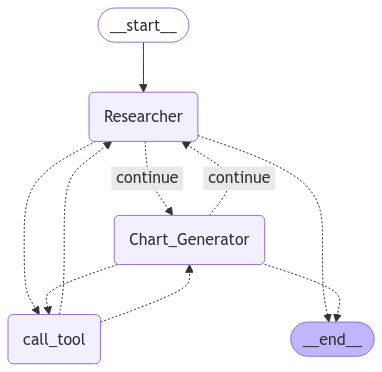

================================ Human Message =================================

Obtain the GDP of the United States from 2000 to 2020, and then plot a line chart with Python. End the task after generating the chart。
================================== Ai Message ==================================
Name: Researcher
Tool Calls:
  tavily_search_results_json (call_nntjXcC8L33Si7lW7haL3s1J)
 Call ID: call_nntjXcC8L33Si7lW7haL3s1J
  Args:
    query: United States GDP from 2000 to 2020
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://www.statista.com/topics/772/gdp/", "content": "U.S. gross domestic product contributions 2000-2021, by sector\nValue added to gross domestic product across economic sectors in the United States from 2000 to 2021 (as a share of GDP)\nU.S. change in real value added to GDP 2022, by industry\nChange in real value added to the gross domestic product of the United States in 2022, by in

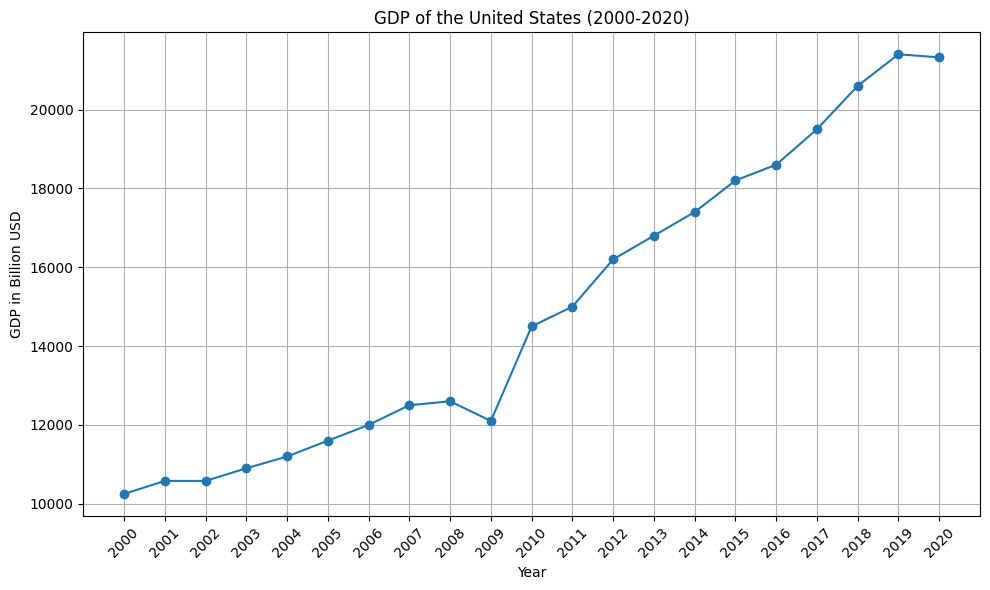

================================= Tool Message =================================
Name: python_repl

Successfully executed:
```python
import matplotlib.pyplot as plt

# Years and GDP data
years = list(range(2000, 2021))
gdp_values = [10250.12, 10580.00, 10580.00, 10900.00, 11200.00, 11600.00, 12000.00,
              12500.00, 12600.00, 12100.00, 14500.00, 15000.00, 16200.00, 16800.00,
              17400.00, 18200.00, 18600.00, 19500.00, 20600.00, 21400.00, 21322.95]

# Plotting the line chart
plt.figure(figsize=(10, 6))
plt.plot(years, gdp_values, marker='o')
plt.title('GDP of the United States (2000-2020)')
plt.xlabel('Year')
plt.ylabel('GDP in Billion USD')
plt.xticks(years, rotation=45)
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()
```

================================== Ai Message ==================================
Name: Chart_Generator

The line chart displaying the GDP of the United States from 2000 to 2020 has been successfully generated. If you need any further 

In [14]:
run_graph_with_specified_model(model="gpt-4o-mini")

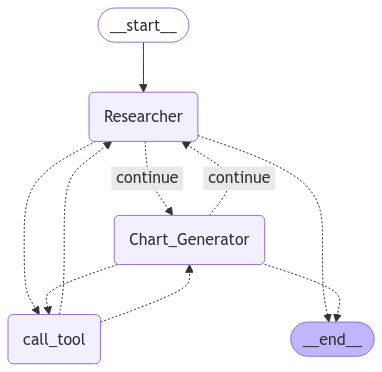

================================ Human Message =================================

Obtain the GDP of the United States from 2000 to 2020, and then plot a line chart with Python. End the task after generating the chart。
================================== Ai Message ==================================
Name: Researcher
Tool Calls:
  tavily_search_results_json (call_GTotlyZ3NaWZ24JlBUqvQRjk)
 Call ID: call_GTotlyZ3NaWZ24JlBUqvQRjk
  Args:
    query: GDP of the United States from 2000 to 2020
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://www.statista.com/topics/772/gdp/", "content": "U.S. gross domestic product contributions 2000-2021, by sector\nValue added to gross domestic product across economic sectors in the United States from 2000 to 2021 (as a share of GDP)\nU.S. change in real value added to GDP 2022, by industry\nChange in real value added to the gross domestic product of the United States in 2022

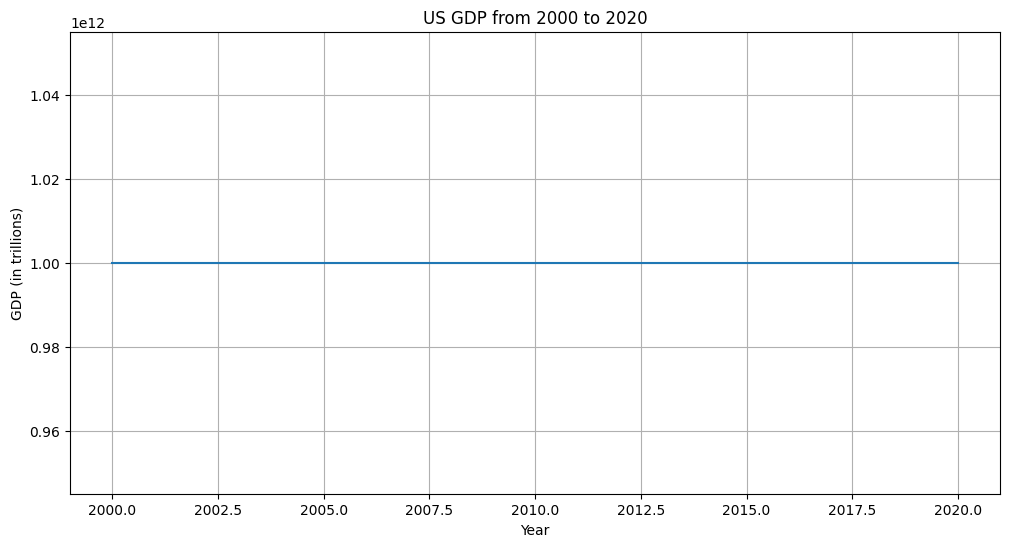

================================= Tool Message =================================
Name: python_repl

Successfully executed:
```python

import pandas as pd
import matplotlib.pyplot as plt

# Placeholder data
# Replace this with the actual data once it's available
years = list(range(2000, 2021))
gdp_values = [10**12]*len(years)  # Placeholder values

df = pd.DataFrame({'Year': years, 'GDP': gdp_values})

plt.figure(figsize=(12, 6))
plt.plot(df['Year'], df['GDP'])
plt.xlabel('Year')
plt.ylabel('GDP (in trillions)')
plt.title('US GDP from 2000 to 2020')
plt.grid(True)
plt.show()

```

================================== Ai Message ==================================
Name: Chart_Generator

I've created a line chart with placeholder data as the actual data for the GDP of the United States from 2000 to 2020 is not available. Once the actual data is available, you can replace the placeholder data with the real GDP values. The chart has years on the x-axis and GDP (in trillions) on the y-axis.

Pl

GraphRecursionError: Recursion limit of 20 reached without hitting a stop condition. You can increase the limit by setting the `recursion_limit` config key.
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/GRAPH_RECURSION_LIMIT

In [15]:
run_graph_with_specified_model(model="gpt-4")

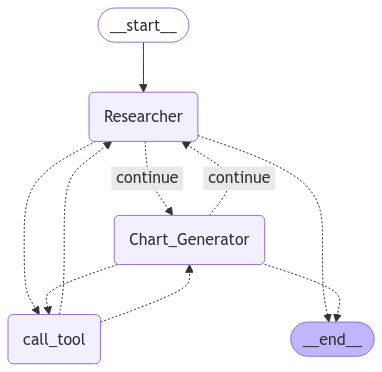

================================ Human Message =================================

Obtain the GDP of the United States from 2000 to 2020, and then plot a line chart with Python. End the task after generating the chart。
================================== Ai Message ==================================
Name: Researcher
Tool Calls:
  tavily_search_results_json (call_IuKJ5FV3EsC90BNzBoAZKiIx)
 Call ID: call_IuKJ5FV3EsC90BNzBoAZKiIx
  Args:
    query: United States GDP annual data from 2000 to 2020
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://www.statista.com/topics/772/gdp/", "content": "U.S. gross domestic product contributions 2000-2021, by sector\nValue added to gross domestic product across economic sectors in the United States from 2000 to 2021 (as a share of GDP)\nU.S. change in real value added to GDP 2022, by industry\nChange in real value added to the gross domestic product of the United States in

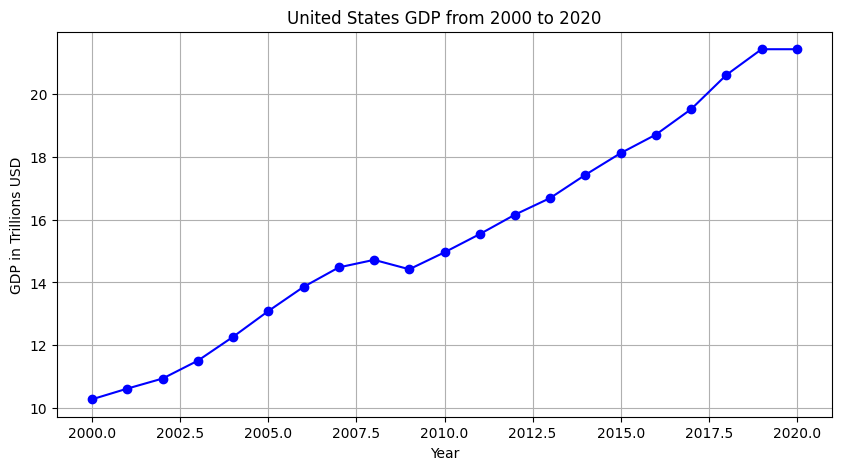

================================== Ai Message ==================================
Name: Chart_Generator
Tool Calls:
  python_repl (call_qLHAKEHXvHKLcvY1xBzS7IZt)
 Call ID: call_qLHAKEHXvHKLcvY1xBzS7IZt
  Args:
    code: import matplotlib.pyplot as plt

# Example data for US GDP from 2000 to 2020 in trillion USD
years = [2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020]
gdp = [10.28, 10.62, 10.94, 11.51, 12.27, 13.09, 13.86, 14.48, 14.72, 14.42, 14.96, 15.54, 16.16, 16.69, 17.43, 18.12, 18.71, 19.52, 20.61, 21.43, 21.43]

plt.figure(figsize=(10, 5))
plt.plot(years, gdp, marker='o', linestyle='-', color='b')
plt.title('United States GDP from 2000 to 2020')
plt.xlabel('Year')
plt.ylabel('GDP in Trillions USD')
plt.grid(True)
plt.show()
================================= Tool Message =================================
Name: python_repl

Successfully executed:
```python
import matplotlib.pyplot as plt

# Example data f

In [16]:
run_graph_with_specified_model(model="gpt-4-turbo")

## 2. 将 Chart Generator 替换为其他功能智能体（如 table_generator），为其设计提示词，然后运行查看生成结果。

In [1]:
import os
# 可选：在 LangSmith 中添加追踪功能
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "Multi-agent Collaboration"

In [2]:
# 1. 定义工具
from typing import Annotated

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool
from langchain_experimental.utilities import PythonREPL

# Tavily 搜索工具，用于搜索
tavily_tool = TavilySearchResults(max_results=5)

# Python REPL 工具，用于执行 Python 代码
repl = PythonREPL()

@tool
def python_repl(
    code: Annotated[str, "The python code to execute to generate your table."],
):
    """Use this to execute python code. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"


    return f"Successfully executed:\n```python\n{code}\n```\n"

        
from langgraph.prebuilt import ToolNode

# 定义工具列表，包括 Tavily 搜索工具和 Python REPL 工具
tools = [tavily_tool, python_repl]

# 创建工具节点，负责工具的调用
tool_node = ToolNode(tools)

In [3]:
# 2. 辅助函数：智能体节点
import functools
from langchain_core.messages import AIMessage
from langchain_openai import ChatOpenAI

# 辅助函数：为智能体创建一个节点
def agent_node(state, agent, name):
    # 修正名称格式，移除空格并确保只包含合法字符
    name = name.replace(" ", "_").replace("-", "_")  # 确保符合正则表达式要求

    # 调用智能体，获取结果
    result = agent.invoke(state)
    
    # 将智能体的输出转换为适合追加到全局状态的格式
    if isinstance(result, ToolMessage):
        pass  # 如果是工具消息，跳过处理
    else:
        # 将结果转换为 AIMessage，并排除部分字段
        result = AIMessage(**result.dict(exclude={"type", "name"}), name=name)
    
    # 返回更新后的状态，包括消息和发送者
    return {
        "messages": [result],  # 包含新生成的消息
        # 我们使用严格的工作流程，通过记录发送者来知道接下来传递给谁
        "sender": name,
    }

In [4]:
# 3. 辅助函数：创建智能体
from langchain_core.messages import BaseMessage, HumanMessage, ToolMessage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langgraph.graph import END, StateGraph, START


# 创建智能体的函数，绑定 LLM（大型语言模型） 和工具
def create_agent(llm, tools, tool_message: str, custom_notice: str=""):
    """创建一个智能体。"""
    # 定义智能体的提示模板，包含系统消息和工具信息
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                "You are a helpful AI assistant, collaborating with other assistants."
                " Use the provided tools to progress towards answering the question."
                " If you are unable to fully answer, that's OK, another assistant with different tools "
                " will help where you left off. Execute what you can to make progress."
                " If you or any of the other assistants have the final answer or deliverable,"
                " prefix your response with FINAL ANSWER so the team knows to stop."
                "\n{custom_notice}\n"
                " You have access to the following tools: {tool_names}.\n{tool_message}\n\n",
            ),
            MessagesPlaceholder(variable_name="messages"),  # 用于替换的消息占位符

        ]
    )

    # 将系统消息部分和工具名称插入到提示模板中
    prompt = prompt.partial(tool_message=tool_message, custom_notice=custom_notice)
    prompt = prompt.partial(tool_names=", ".join([tool.name for tool in tools]))
      
    # 将提示模板与语言模型和工具绑定
    return prompt | llm.bind_tools(tools)


In [5]:
import operator
from typing import Annotated, Sequence, TypedDict

# 定义图中传递的对象，包含消息和发送者信息
class AgentState(TypedDict):
    # messages 是传递的消息，使用 Annotated 和 Sequence 来标记类型
    messages: Annotated[Sequence[BaseMessage], operator.add]
    # sender 是发送消息的智能体
    sender: str

In [6]:
from typing import Literal

# 路由器函数，用于决定下一步是执行工具还是结束任务
def router(state) -> Literal["call_tool", "__end__", "continue"]:
    messages = state["messages"]  # 获取当前状态中的消息列表
    last_message = messages[-1]  # 获取最新的一条消息
    
    # 如果最新消息包含工具调用，则返回 "call_tool"，指示执行工具
    if last_message.tool_calls:
        return "call_tool"
    
    # 如果最新消息中包含 "FINAL ANSWER"，表示任务已完成，返回 "__end__" 结束工作流
    if "FINAL ANSWER" in last_message.content:
        return "__end__"
    
    # 如果既没有工具调用也没有完成任务，继续流程，返回 "continue"
    return "continue"

In [7]:
def create_research_node(model="gpt-4o-mini"):
    # 研究智能体及其节点
    research_llm = ChatOpenAI(model=model)
    research_agent = create_agent(
        research_llm,  # 使用 research_llm 作为研究智能体的语言模型
        [tavily_tool],  # 研究智能体使用 Tavily 搜索工具
        tool_message=(
            "Before using the search engine, carefully think through and clarify the query."
            " Then, conduct a single search that addresses all aspects of the query in one go",
        ),
        custom_notice=(
            "Notice:\n"
            "Only gather and organize information. Do not generate code or give final conclusions, leave that for other assistants."
        ),
    )
    research_node = functools.partial(agent_node, agent=research_agent, name="Researcher")
    return research_node

In [8]:
def create_table_node(model="gpt-4o-mini"):
    # 图表生成器智能体及其节点
    table_llm = ChatOpenAI(model=model)
    table_agent = create_agent(
        table_llm,  # 使用 chart_llm 作为图表生成器智能体的语言模型
        [python_repl],  # 图表生成器智能体使用 Python REPL 工具
        tool_message="Create clear and user-friendly tables based on the provided data.",  # 系统消息，指导智能体如何生成图表
        custom_notice="Notice:\n"
        "If you have completed all tasks, respond with FINAL ANSWER.",
    )
    table_node = functools.partial(agent_node, agent=table_agent, name="Table_Generator")
    return table_node

In [9]:
def create_workflow_gen_table(research_node, table_node):
    # 创建一个状态图 workflow，使用 AgentState 来管理状态
    workflow = StateGraph(AgentState)
    
    # 将研究智能体节点、图表生成器智能体节点和工具节点添加到状态图中
    workflow.add_node("Researcher", research_node)
    workflow.add_node("Table_Generator", table_node)
    workflow.add_node("call_tool", tool_node)
    # 为 "Researcher" 智能体节点添加条件边，根据 router 函数的返回值进行分支
    workflow.add_conditional_edges(
        "Researcher",
        router,  # 路由器函数决定下一步
        {
            "continue": "Table_Generator",  # 如果 router 返回 "continue"，则传递到 Chart_Generator
            "call_tool": "call_tool",  # 如果 router 返回 "call_tool"，则调用工具
            "__end__": END  # 如果 router 返回 "__end__"，则结束工作流
        },
    )
    
    # 为 "Chart_Generator" 智能体节点添加条件边
    workflow.add_conditional_edges(
        "Table_Generator",
        router,  # 同样使用 router 函数决定下一步
        {
            "continue": "Researcher",  # 如果 router 返回 "continue"，则回到 Researcher
            "call_tool": "call_tool",  # 如果 router 返回 "call_tool"，则调用工具
            "__end__": END  # 如果 router 返回 "__end__"，则结束工作流
        },
    )
    
    # 为 "call_tool" 工具节点添加条件边，基于“sender”字段决定下一个节点
    # 工具调用节点不更新 sender 字段，这意味着边将返回给调用工具的智能体
    workflow.add_conditional_edges(
        "call_tool",
        lambda x: x["sender"],  # 根据 sender 字段判断调用工具的是哪个智能体
        {
            "Researcher": "Researcher",  # 如果 sender 是 Researcher，则返回给 Researcher
            "Table_Generator": "Table_Generator",  # 如果 sender 是 Chart_Generator，则返回给 Chart_Generator
        },
    )
    # 添加开始节点，将流程从 START 节点连接到 Researcher 节点
    workflow.add_edge(START, "Researcher")
    return workflow

In [10]:
def compile_workflow(workflow):
    # 编译状态图以便后续使用
    graph = workflow.compile()
    # 可视化图
    from IPython.display import Image, display
    
    try:
        display(
            Image(
                graph.get_graph(xray=True).draw_mermaid_png()
            )
        )
    except Exception as e:
        print(f"Error generating graph: {e}")
    
    return graph

In [11]:
def run_graph_gen_table(model="gpt-4o-mini"):
    research_node = create_research_node(model)
    table_node = create_table_node(model)
    workflow = create_workflow_gen_table(research_node, table_node)
    graph = compile_workflow(workflow)

    events = graph.stream(
        {
            "messages": [
                HumanMessage(
                    content="Obtain the GDP of the United States from 2000 to 2020, "
                "and then generate a data table with Python. End the task after generating the table."
                )
            ],
        },
        # 设置最大递归限制
        {"recursion_limit": 20},
        stream_mode="values"
    )
    
    for event in events:
        if "messages" in event:
            event["messages"][-1].pretty_print()  # 打印消息内容

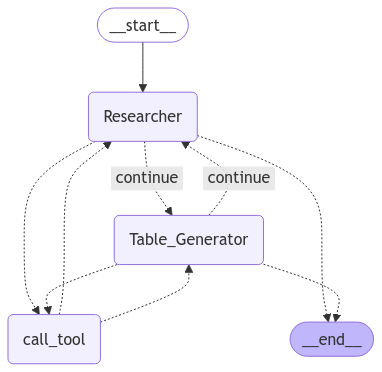

================================ Human Message =================================

Obtain the GDP of the United States from 2000 to 2020, and then generate a data table with Python. End the task after generating the table.
================================== Ai Message ==================================
Name: Researcher
Tool Calls:
  tavily_search_results_json (call_c2iSVu1zEl0ysYpMlroDMyfe)
 Call ID: call_c2iSVu1zEl0ysYpMlroDMyfe
  Args:
    query: United States GDP from 2000 to 2020
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://www.multpl.com/us-gdp-inflation-adjusted/table/by-year", "content": "US Real GDP table by year, historic, and current data. Current US Real GDP is 23.22 trillion. ... 2020 20.77 trillion Dec 31, 2019 20.99 trillion Dec 31, 2018 20.30 trillion Dec 31, 2017 ... 2000 14.23 trillion Dec 31, 1999 13.83 trillion Dec 31, 1998 13.19 trillion Dec 31, 1997"}, {"url": "https://data.world

Python REPL can execute arbitrary code. Use with caution.


================================== Ai Message ==================================
Name: Table_Generator
Tool Calls:
  python_repl (call_eKqhXw080ImG2n1pydEv8FLW)
 Call ID: call_eKqhXw080ImG2n1pydEv8FLW
  Args:
    code: import pandas as pd

data = {
    'Year': [2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009,
             2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020],
    'GDP (Trillions USD)': [14.23, 10.58, 10.58, 10.87, 11.23, 11.68, 12.29, 12.96,
                            13.14, 13.06, 14.66, 15.06, 15.37, 15.67, 16.16, 16.79,
                            17.36, 18.12, 20.30, 20.99, 20.77]
}

gdp_table = pd.DataFrame(data)
print(gdp_table)
================================= Tool Message =================================
Name: python_repl

Successfully executed:
```python
import pandas as pd

data = {
    'Year': [2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009,
             2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020],


In [12]:
run_graph_gen_table(model="gpt-4o-mini")